# $\Lambda_b \rightarrow pK\mu\tau$ documentation: background reduction

## Background reduction
The background was reduced in several ways: 
1. There were some inconsistencies in the data (structures at low values of momentum or PID), which were removed
2. Some known cuts were present in the data and were removed
3. Some events properties were compared between background and a $J/\Psi$ comparison channel in order to find optimal cuts 
4. Properties of events were optimised with a boosted decision tree.

For most of the background reduction, we will not need specific data about the tau, apart in the BDT, where we will apply a cut on the tau flight distance.

## Loading the data and imports
The data can be loaded by calling the `load data` function. 
Three types of data sets can be obtained: real data (`Lb_data`), B Monte Carlo data (`B_MC`) and $\Lambda_b$ Monte Carlo data (`Lb_MC`).

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from data.data_loader import load_data
from masses import get_mass
from masses import masses
from plotting_functions import plot_compare_data
from ip_calculations import line_point_distance


df_name = 'Lb_data'
data_frame = load_data(df_name=df_name)


RangeIndex(start=0, stop=294631, step=1)


## Cleaning cuts on the data

We could observe several inconsistencies in the data, which were removed.

### Momentum inconsistencies
We could see inconsistencies in the momentum distributions of the proton and muons, as outlined below.
The cuts used are as follows:
* events with mu1_P below 10GeV were discarded
* events with tauMu_P below 10GeV were discarded
* events with mu1_PT below 1.5GeV were discarded
* events with tauMu_PT below 1.5GeV were discarded
* events with proton_P below 15GeV were discarded
* events with proton_PT below 1GeV were discarded

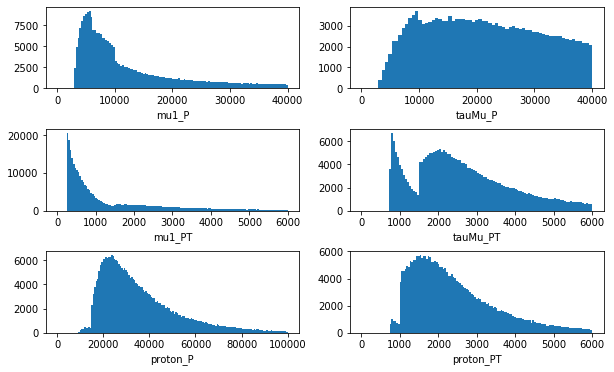

In [37]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, gridspec_kw={'hspace': 0.5}, figsize=(10, 6))
ax1.hist(data_frame['mu1_P'], bins='auto', range=[0, 40000])
ax1.set_xlabel('mu1_P')
ax2.hist(data_frame['tauMu_P'], bins='auto', range=[0, 40000])
ax2.set_xlabel('tauMu_P')
ax3.hist(data_frame['mu1_PT'], bins='auto', range=[0, 6000])
ax3.set_xlabel('mu1_PT')
ax4.hist(data_frame['tauMu_PT'], bins='auto', range=[0, 6000])
ax4.set_xlabel('tauMu_PT')
ax5.hist(data_frame['proton_P'], bins='auto', range=[0, 100000])
ax5.set_xlabel('proton_P')
ax6.hist(data_frame['proton_PT'], bins='auto', range=[0, 6000])
ax6.set_xlabel('proton_PT')
plt.show()

### PID inconsistencies
PID inconsistencies were removed as follows:
* events with a proton_PIDp lower than 10 were removed
* events with proton_PIDp - proton_PIDK lower than 10 were removed

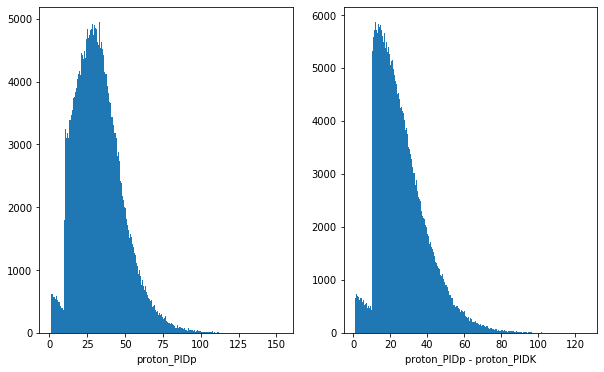

In [38]:
fig_pid, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist(data_frame['proton_PIDp'], bins='auto')
ax1.set_xlabel('proton_PIDp')
ax2.hist(data_frame['proton_PIDp'] - data_frame['proton_PIDK'], bins='auto')
ax2.set_xlabel('proton_PIDp - proton_PIDK')
plt.show()

Here we apply the cleaning mentioned above.

In [32]:
proton_P_threshold = 15e3
proton_PT_threshold = 1000
mu1_P_threshold = 10e3
mu1_PT_threshold = 1500
tauMu_P_threshold = 10e3
tauMu_PT_threshold = 1500
proton_PIDp_threshold = 10
proton_PIDpK_threshold = 10

data_frame = data_frame[data_frame['proton_P'] > proton_P_threshold]
data_frame = data_frame[data_frame['proton_PT'] > proton_PT_threshold]
data_frame = data_frame[data_frame['mu1_P'] > mu1_P_threshold]
data_frame = data_frame[data_frame['mu1_PT'] > mu1_PT_threshold]
data_frame = data_frame[data_frame['tauMu_P'] > tauMu_P_threshold]
data_frame = data_frame[data_frame['tauMu_PT'] > tauMu_PT_threshold]
data_frame = data_frame[data_frame['proton_PIDp'] > proton_PIDp_threshold]
data_frame = data_frame[data_frame['proton_PIDp'] - data_frame['proton_PIDK'] > proton_PIDpK_threshold]

## Comparisons with $J/\psi$ control channel
Attributes of the $J/\psi$ data were compared with attributes of the background.
Attributes consisted in
1. PID cuts
2. IP cuts
3. Isolation angle cuts
4. $\chi^2$ cuts
5. IP* cuts
Comparisons leading to cuts are outlined below.

### Defining control and background
The dimuon mass of the data frame was obtained with `get_mass`. 
Then the contol data was defined as data with a mass close to the $\Lambda_b$ mass and a dimuon mass close to the $J/\psi$ mass.
A plot of the dimuon mass shows a clear peak at the $J/\psi$ resonance.

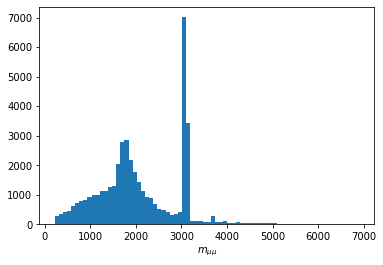

In [40]:
particles_associations = [['mu1_P', 'mu'], ['tauMu_P', 'mu']]
data_frame['dimuon_mass'] = get_mass(data_frame=data_frame, particles_associations=particles_associations)
compare_data = data_frame[(data_frame['dimuon_mass'] < 3150) & (data_frame['dimuon_mass'] > 3050)]
compare_data = compare_data[(compare_data['Lb_M'] < 5650) & (compare_data['Lb_M'] > 5590)]
background_selection = data_frame[(data_frame['Lb_M'] > 5800)]
plt.hist(data_frame['dimuon_mass'], bins='auto')
plt.xlabel('$m_{\mu\mu}$')
plt.show()

### PID comparisons
Several cuts could be applied by comparing PID distributions between our background and control channel.
Firstly, we can observe a peak close to the $D_0$ mass in the dimuon mass plot. 
In this peak, we can observe a structure at low PID when plotting a 2d histogram of the muon PID. 
Removing events with a mu1_PIDmu and a tauMu_PIDmu lower than 5 solves the problem and a much smoother dimuon mass distribution can be observed.
The misidentifications at low muon PID will be explored more in the next section.

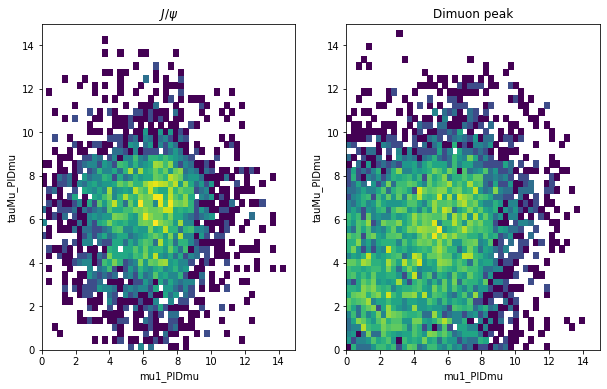

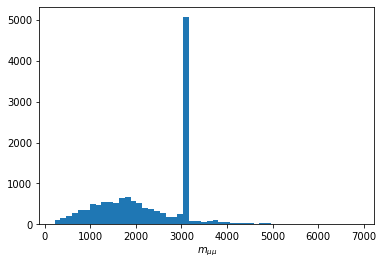

In [58]:

mu_peak = data_frame[(data_frame['dimuon_mass'] > 1600) & (data_frame['dimuon_mass'] < 2000)]
fig_pid_comp, axs = plt.subplots(1, 2, gridspec_kw={'hspace': 0.5}, figsize=(10, 6))
axs[0].hist2d(compare_data['mu1_PIDmu'], compare_data['tauMu_PIDmu'], bins=50, range=[[0, 15], [0, 15]],
              norm=LogNorm())
axs[0].set_xlabel('mu1_PIDmu')
axs[0].set_ylabel('tauMu_PIDmu')
axs[0].set_title('$J/\psi$')

axs[1].hist2d(mu_peak['mu1_PIDmu'], mu_peak['tauMu_PIDmu'], bins=50, range=[[0, 15], [0, 15]], norm=LogNorm())
axs[1].set_xlabel('mu1_PIDmu')
axs[1].set_ylabel('tauMu_PIDmu')
axs[1].set_title('Dimuon peak')
plt.show()

a = data_frame[(data_frame['tauMu_PIDmu'] > 5)]
a = a[(a['mu1_PIDmu'] > 5)]

plt.hist(a['dimuon_mass'], bins='auto')
plt.xlabel('$m_{\mu\mu}$')
plt.show()

Several other PID cuts were applied on the data, as follows:
* proton_PIDp > 15
* Kminus_PIDK > 10
* proton_PIDp - proton_PIDK > 15
* Kminus_PIDK - proton_PIDp > 10
* Kminus_PIDK - Kminus_PIDmu > 10
* mu1_PIDmu - mu1_PIDK > 15]

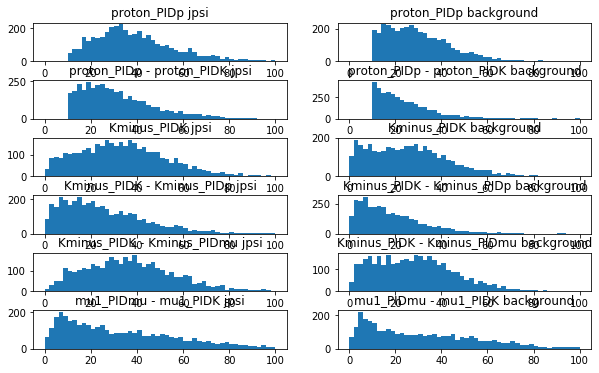

In [71]:
background_selection = background_selection.reset_index(drop=True)
compare_data = compare_data.reset_index(drop=True)
plot_compare_data(compare_data, background_selection, 
                  histogram_range=100,
                  columns_to_plot=['proton_PIDp', ['proton_PIDp', 'proton_PIDK'],
                                   'Kminus_PIDK', ['Kminus_PIDK', 'Kminus_PIDp'],  ['Kminus_PIDK', 'Kminus_PIDmu'], 
                                   ['mu1_PIDmu', 'mu1_PIDK']], 
                  signal_name='jpsi')

### IP comparisons
Comparing the impact parameter $\chi^2$ of the $J/\psi$ leads us to apply the following cuts:
* tauMu_IPCHI2_OWNPV > 9
* mu1_IPCHI2_OWNPV > 9
* Kminus_IPCHI2_OWNPV > 9
* proton_IPCHI2_OWNPV > 16 (a cut seems to have been inconsistently applied on the data)

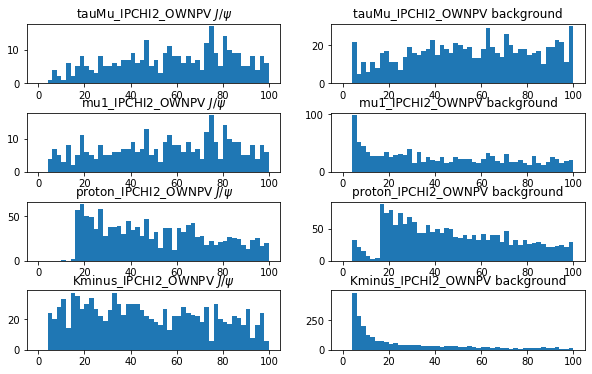

In [73]:
plot_compare_data(compare_data, background_selection, histogram_range=100,
                          columns_to_plot=['tauMu_IPCHI2_OWNPV', 'mu1_IPCHI2_OWNPV', 'proton_IPCHI2_OWNPV',
                                           'Kminus_IPCHI2_OWNPV'], signal_name='$J/\psi$')

### Isolation angle comparisons
The background and $J/\psi$ data have different isolation angle distributions, with the background having a distribution peaked at a higher value.
We used data with an isolation angle below 0.

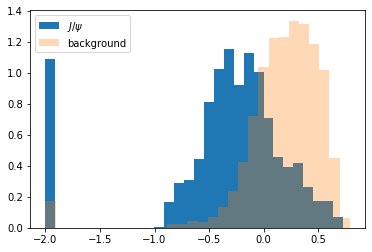

In [76]:
plt.hist(compare_data['Lb_pmu_ISOLATION_BDT1'], bins=30, density=True, label='$J/\psi$')
plt.hist(background_selection['Lb_pmu_ISOLATION_BDT1'], bins=30, density=True, alpha=0.3, label='background')
plt.xlabel('Isolation angle (normalised)')
plt.legend()
plt.show()


### $\chi^2$ comparisons
Two additional variables were cut on, with the following requirements
* pKmu_ENDVERTEX_CHI2 < 9
* Lb_FDCHI2_OWNPV > 300

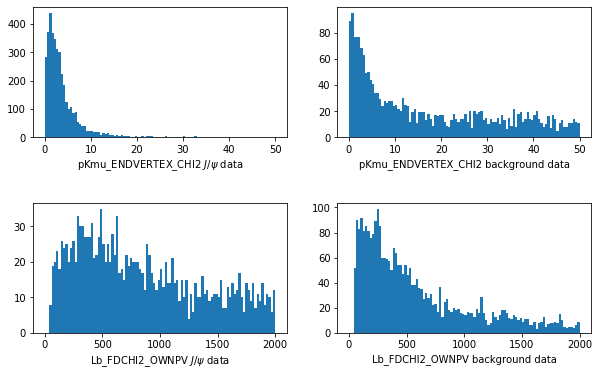

In [83]:
fig_chi2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw={'hspace': 0.5}, figsize=(10, 6))
ax1.hist(compare_data['pKmu_ENDVERTEX_CHI2'], bins=100, range=[0, 50])
ax1.set_xlabel('pKmu_ENDVERTEX_CHI2 $J/\psi$ data')
ax2.hist(background_selection['pKmu_ENDVERTEX_CHI2'], bins=100, range=[0, 50])
ax2.set_xlabel('pKmu_ENDVERTEX_CHI2 background data')
ax3.hist(compare_data['Lb_FDCHI2_OWNPV'], bins=100, range=[0, 2000])
ax3.set_xlabel('Lb_FDCHI2_OWNPV $J/\psi$ data')
ax4.hist(background_selection['Lb_FDCHI2_OWNPV'], bins=100, range=[0, 2000])
ax4.set_xlabel('Lb_FDCHI2_OWNPV background data')
plt.show()

### IP* comparisons
We define IP* as the impact parameter between tauMu and the pKmu vertex.
One further cut was applied, considering this time a different kind of background. 
As outlined below, we can observe $\Lambda_b\rightarrow \Lambda_c\mu\nu$ events in the data.
Some of those events are characterised with a IP* much more negative than for $J/\psi$ data.
Here we plot IP* for events where the proton has the same charge as the mu1 (`proton_ID != mu1_ID`).
Events with IP* below -0.02 were removed.

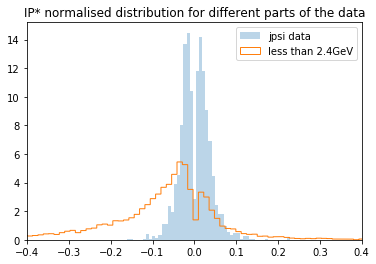

In [33]:
data_frame = data_frame.reset_index(drop=True)
data_frame['vector_muTau'] = data_frame[['tauMu_PX', 'tauMu_PY', 'tauMu_PZ']].values.tolist()
data_frame['tauMu_reference_point'] = data_frame[['tauMu_REFPX', 'tauMu_REFPY', 'tauMu_REFPZ']].values.tolist()
data_frame['pkmu_endvertex_point'] = data_frame[
    ['pKmu_ENDVERTEX_X', 'pKmu_ENDVERTEX_Y', 'pKmu_ENDVERTEX_Z']].values.tolist()
data_frame['pkmu_direction'] = data_frame[['pKmu_PX', 'pKmu_PY', 'pKmu_PZ']].values.tolist()
data_frame['ip_star'] = line_point_distance(vector=data_frame['vector_muTau'],
                                                                vector_point=data_frame['tauMu_reference_point'],
                                                                point=data_frame['pkmu_endvertex_point'],
                                                                direction=data_frame['pkmu_direction'])
particles_associations = [['Kminus_P', 'K'], ['proton_P', 'proton'], ['mu1_P', 'mu']]
data_frame['pkmu_mass1'] = get_mass(data_frame=data_frame, particles_associations=particles_associations)
plt.hist(np.load(f'C:\\Users\\Hanae\\Documents\\MSci Project\\MsciCode\\ipstar_jpsi_sign.npy'),
                 label='jpsi data', density=True, alpha=0.3, bins='auto')
df_lc = data_frame[data_frame['proton_ID'] != data_frame['mu1_ID']]
plt.hist(df_lc[(df_lc['pkmu_mass1'] < 2400)]['ip_star'], label='less than 2.4GeV', 
         density=True, histtype='step', bins='auto')
plt.title('IP* normalised distribution for different parts of the data')
plt.xlim((-0.4, 0.4))
plt.legend()
plt.show()

### Applying all comparisons cuts
This cell applies all cuts mentioned above, apart from the IP* cut which will be applied at the same time as the $\Lambda_c$ cut.

In [34]:
# PID cuts
data_frame = data_frame[(data_frame['tauMu_PIDmu'] > 5)]
data_frame = data_frame[(data_frame['mu1_PIDmu'] > 5)]
data_frame = data_frame[data_frame['Kminus_PIDK'] - data_frame['Kminus_PIDp'] > 10]
data_frame = data_frame[data_frame['Kminus_PIDK'] - data_frame['Kminus_PIDmu'] > 10]
data_frame = data_frame[data_frame['Kminus_PIDK'] > 10]
data_frame = data_frame[data_frame['proton_PIDp'] > 15] 
data_frame = data_frame[data_frame['proton_PIDp'] - data_frame['proton_PIDK'] > 15]  # or 9?
data_frame = data_frame[data_frame['mu1_PIDmu'] - data_frame['mu1_PIDK'] > 15]  # 9 or not?
# impact parameter cuts
data_frame = data_frame[data_frame['tauMu_IPCHI2_OWNPV'] > 9]
data_frame = data_frame[data_frame['proton_IPCHI2_OWNPV'] > 16]
data_frame = data_frame[data_frame['Kminus_IPCHI2_OWNPV'] > 9]
data_frame = data_frame[data_frame['mu1_IPCHI2_OWNPV'] > 9]
# isolation angle cut
data_frame = data_frame[data_frame['Lb_pmu_ISOLATION_BDT1'] < 0]
# chi2 cuts
data_frame = data_frame[data_frame['pKmu_ENDVERTEX_CHI2'] < 9]
data_frame = data_frame[data_frame['Lb_FDCHI2_OWNPV'] > 300]


## Removing known events

Several mass cuts were obtained in order to see if peaks were present at low masses. We see that the following events seem to be present in the data:
1. $\Lambda_b\rightarrow pKJ/\psi$ and $\Lambda_b\rightarrow pK\psi (2S)$ events
2. $\Lambda_b\rightarrow \Lambda_c\mu\nu$ events 
3. $\Lambda_b\rightarrow p D_0\mu\nu$

No cuts were applied on the third kind of events, because tests on the Monte Carlo data showed that a pure mass cuts on the $K\mu$ mass would reduce drastically the number of events.
If a Monte Carlo sample of that decay was available, we might be able to remove those events more effectively.

### $\Lambda_b\rightarrow pKJ/\psi$ and $\Lambda_b\rightarrow pK\psi (2S)$ events
We see peaks in the dimuon mass close to the $J/\psi$ and $\psi (2S)$ masses. As the branching fractions of $\Lambda_b\rightarrow pKJ/\psi$ and $\Lambda_b\rightarrow pK\psi (2S)$ are much higher than the decays we are probing, we decided to remove events with a dimuon mass close to those resonance.
For the $\psi (2S)$, we removed events with a dimuon mass within 50MeV of the $\psi (2S)$ on both sides.
For the $J/\psi$ resonance, we removed events within 250MeV on the low side and 50MeV on the high side.
In the following plot, the removed data is in the red zone.

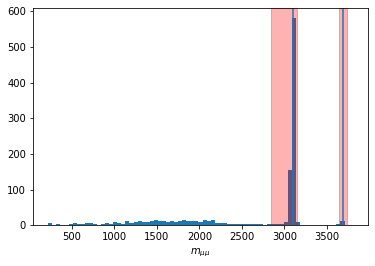

In [24]:
particles_associations = [['mu1_P', 'mu'], ['tauMu_P', 'mu']]
data_frame['dimuon_mass'] = get_mass(data_frame=data_frame, particles_associations=particles_associations)
plt.hist(data_frame['dimuon_mass'], bins=75)
plt.axvline(masses['J/psi'])
plt.axvline(masses['psi(2S)'])
jpsi_limits = [masses['J/psi'] - 250, masses['J/psi'] + 50]
psi2s_limits = [masses['psi(2S)'] - 50, masses['psi(2S)'] + 50]
plt.axvspan(jpsi_limits[0], jpsi_limits[1], color='red', alpha=0.3)  # [2828, 3317]
plt.axvspan(psi2s_limits[0], psi2s_limits[1], color='red', alpha=0.3)  # [2828, 3317]
plt.xlabel('$m_{\mu\mu}$')
plt.show()
data_frame = data_frame[
        (data_frame['dimuon_mass'] > masses['J/psi'] + 50) | (data_frame['dimuon_mass'] < masses['J/psi'] - 250)]
data_frame = data_frame[
        (data_frame['dimuon_mass'] > masses['psi(2S)'] + 50) | (data_frame['dimuon_mass'] < masses['psi(2S)'] - 50)]

### $\Lambda_b\rightarrow \Lambda_c\mu\nu$ events 
We see a peak in the $pK\mu$ mass at the $\Lambda_c$ mass (where p and $\mu$ have the same charge). 
We expect several $pK\mu\nu$ events to accumulate below that mass, and IP* analyses show that a cut at 2.8GeV might be better than at 2.4GeV.

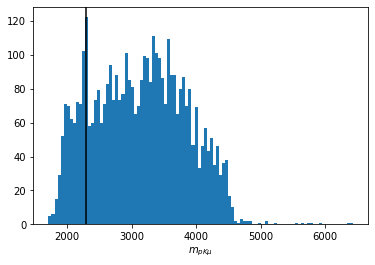

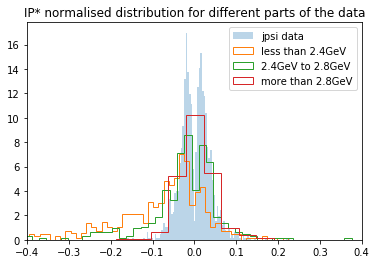

In [35]:
data_frame = data_frame.reset_index(drop=True)
particles_associations = [['Kminus_P', 'K'], ['proton_P', 'proton'], ['mu1_P', 'mu']]
data_frame['pkmu_mass1'] = get_mass(data_frame=data_frame, particles_associations=particles_associations)
particles_associations = [['Kminus_P', 'K'], ['proton_P', 'proton'], ['tauMu_P', 'mu']]
data_frame['pkmu_mass2'] = get_mass(data_frame=data_frame, particles_associations=particles_associations)
plt.hist([data_frame[data_frame['proton_ID'] != data_frame['mu1_ID']]['pkmu_mass1'], 
          data_frame[data_frame['proton_ID'] != data_frame['tauMu_ID']]['pkmu_mass2']], 
         bins=100, stacked=True, color=['C0', 'C0'])
plt.axvline(masses['Lc'], c='k')
plt.xlabel('$m_{pK\mu}$')
plt.show()

_range, _bins = [-0.4, 0.4], 100
df_lc = data_frame[data_frame['proton_ID'] != data_frame['mu1_ID']]
plt.hist(np.load(f'C:\\Users\\Hanae\\Documents\\MSci Project\\MsciCode\\ipstar_jpsi_sign.npy'),
         label='jpsi data',
         density=True, alpha=0.3, bins=_bins)
plt.hist(df_lc[(df_lc['pkmu_mass1'] < 2400)]['ip_star'], label='less than 2.4GeV',
         density=True, histtype='step', bins=_bins)
plt.hist(df_lc[(df_lc['pkmu_mass1'] > 2400) & (df_lc['pkmu_mass1'] < 2800)][
             'ip_star'], label='2.4GeV to 2.8GeV', histtype='step', density=True, bins=_bins)
plt.hist(df_lc[df_lc['pkmu_mass1'] > 2800]['ip_star'], label='more than 2.8GeV',
         histtype='step', density=True, bins=_bins)
plt.title('IP* normalised distribution for different parts of the data')
plt.xlim(_range)
plt.legend()
plt.show()

# ip* cuts (requires to run previous cell which defines ip_star)
data_frame = data_frame[data_frame['ip_star'] > -0.02]
proton_mu1 = data_frame[data_frame['proton_ID'] != data_frame['mu1_ID']]
proton_taumu = data_frame[data_frame['proton_ID'] != data_frame['tauMu_ID']]
data_frame = data_frame.drop(list((proton_mu1[proton_mu1['pkmu_mass1'] < 2800]).index))
data_frame = data_frame.drop(list((proton_taumu[proton_taumu['pkmu_mass2'] < 2800]).index))

### Further proton PID cleaning
After applying those cuts, the `proton_PID` distribution of the cleaned data looks different from the distirbution in the $J/\psi$ data.
As a result we increased the `proton_PID` threshold from 15 to 25.

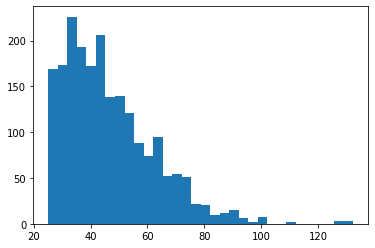

In [37]:
plt.hist(data_frame['proton_PIDp'], bins='auto')
plt.xlabel('proton_PIDp')
plt.show()

data_frame = data_frame[data_frame['proton_PIDp'] > 25]